# Data Mining Cup Task - 2019

### For Predictive Analytics, all homework assignments are building on constructing a solution for the 2019 Data Mining Cup task. This folder is for combining all homework code to construct a final solution.

In [1]:
## Importing all necessary libraries:

import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report

In [2]:
## Reading in the data sets

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


## Initial Exploration

## Variable Engineering

[Text(558.0, 761.04, 'trustLevel <= 1.5\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(279.0, 543.6, 'lineItemVoidsPerPosition <= 0.43\ngini = 0.395\nsamples = 266\nvalue = [194, 72]'),
 Text(139.5, 326.15999999999997, 'lineItemVoids <= 7.5\ngini = 0.492\nsamples = 151\nvalue = [85, 66]'),
 Text(69.75, 108.72000000000003, 'gini = 0.439\nsamples = 120\nvalue = [81, 39]'),
 Text(209.25, 108.72000000000003, 'gini = 0.225\nsamples = 31\nvalue = [4, 27]'),
 Text(418.5, 326.15999999999997, 'valuePerSecond <= 0.003\ngini = 0.099\nsamples = 115\nvalue = [109, 6]'),
 Text(348.75, 108.72000000000003, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(488.25, 108.72000000000003, 'gini = 0.084\nsamples = 114\nvalue = [109, 5]'),
 Text(837.0, 543.6, 'grandTotal <= 98.36\ngini = 0.018\nsamples = 1237\nvalue = [1226, 11]'),
 Text(697.5, 326.15999999999997, 'trustLevel <= 2.5\ngini = 0.013\nsamples = 1215\nvalue = [1207, 8]'),
 Text(627.75, 108.72000000000003, 'gini = 0.057\nsamples = 272\n

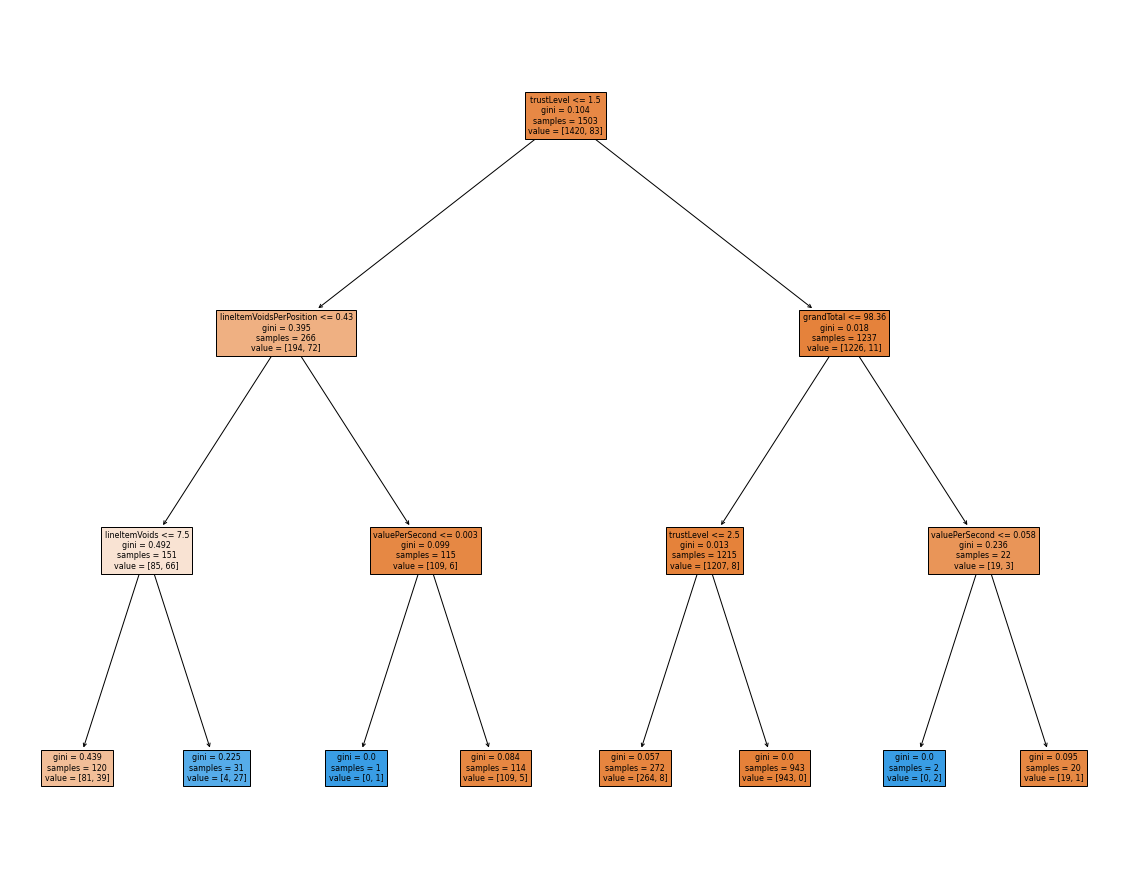

In [13]:
## Creating decision tree to find new feature relationships

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [14]:
train['Interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] <= 0.43) & 
                                  (train['lineItemVoids'] <= 7.5), 1, 0)
test['Interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['lineItemVoidsPerPosition'] <= 0.43) & 
                                  (test['lineItemVoids'] <= 7.5), 1, 0)


train['Interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['lineItemVoidsPerPosition'] > 0.43) & 
                                  (train['valuePerSecond'] <= 0.003), 1, 0)
test['Interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['lineItemVoidsPerPosition'] > 0.43) & 
                                  (test['valuePerSecond'] <= 0.003), 1, 0)


train['Interaction_3'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] <= 98.36) & 
                                  (train['trustLevel'] <= 2.5), 1, 0)
test['Interaction_3'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] <= 98.36) & 
                                  (test['trustLevel'] <= 2.5), 1, 0)


train['Interaction_4'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] > 98.36) & 
                                  (train['valuePerSecond'] <= 0.058), 1, 0)
test['Interaction_4'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] > 98.36) & 
                                  (test['valuePerSecond'] <= 0.058), 1, 0)


train = pd.concat([train.drop(columns = ['trustLevel']), pd.get_dummies(train['trustLevel'])], axis = 1)
test = pd.concat([test.drop(columns = ['trustLevel']), pd.get_dummies(test['trustLevel'])], axis = 1)

In [21]:
train = train.rename(columns = {1: 'trustLevel_1', 2: 'trustLevel_2', 3: 'trustLevel_3', 4: 'trustLevel_4', 
                                5: 'trustLevel_5', 6: 'trustLevel_6'})

In [22]:
train.head(10)

,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,Interaction_1,Interaction_2,Interaction_3,Interaction_4,trustLevel_1,trustLevel_2,trustLevel_3,trustLevel_4,trustLevel_5,trustLevel_6
0,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,0,0,0,0,0,0,0,0,1,0
1,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,0,0,0,0,0,0,1,0,0,0
2,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,0,0,0,0,0,0,1,0,0,0
3,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,0,0,0,0,0,0,0,0,0,1
4,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,0,0,0,0,0,0,0,0,1,0
5,770,11.09,11,5,2,0.033766,0.014403,0.423077,1,0,0,0,0,1,0,0,0,0,0
6,294,55.63,2,7,1,0.037415,0.189218,0.181818,0,0,0,0,0,0,0,1,0,0,0
7,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0,0,0,1,0,0,1,0,0,0,0
8,962,65.44,7,0,2,0.028067,0.068025,0.259259,0,0,0,0,0,0,0,0,0,0,1
9,725,41.08,10,2,4,0.037241,0.056662,0.370370,0,0,0,1,0,0,1,0,0,0,0


In [4]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [5]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [6]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [7]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [8]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [9]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [10]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [11]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [12]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0


In [13]:
train.head(10)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0
